In [2]:
__author__ = "Kaylyn Vo"
__last_updated__ = '1/17/2021'

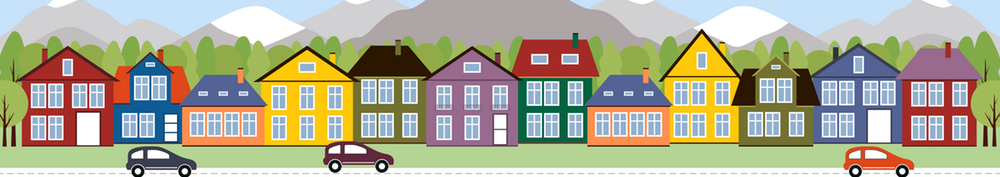

### Table of Contents

* #### [1. Summary](#Summary)

* #### [2. Import Libraries](#Import_Libraries)

* #### [3. About the Data](#About_the_Data_set)

* #### [4. Exploratory Data Analysis](#Exploratory_Data_Analysis)
    * [4.A. Quick Examining of the Data](#Quick_Examining)
    * [4.B. Missing Values](#Handling_Missing_Values)
        * [4.B.1. Unrelated missing features](#Unrelated_missings)
        * [4.B.2. Basement missing features](#bmst_missings)
        * [4.B.3. Garage missing features](#garage_missings)
    * [4.C. Outliers](#outliers)
    
* #### [5. Features Engineering](#features_engineering)
    * [5.A. Creating New Features](#creating_new_Features)
    * [5.B. Modified Years-Related Variables](#modified_years)
    * [5.C. Modified Variables' Type](#modified_type)
    
* #### [6. Data Visualizations](#Data_visualizations)
    * [6.A. Correlation Between Variables](#Correlations)
    * [6.B. Principal Component Analysis](#pca)
    * [6.C. Scatter Plots of Numeric Features](#Scatter_plots)
    * [6.D. Distributions Plots](#Distributions)
        * [6.D.1. Quality Rating Variables](#Quality_related)
        * [6.D.2. House Style and Building Type](#style)
        * [6.D.3. Year Built](#year_built)
        * [6.D.4. Neighboorhood](#Neighborhood)
        
* #### [7. Helper Functions](#Helper_Functions)
    
* #### [8. Modelling](#Modelling)
    * [8.A. Checking for Normality Assumptions](#Normality_Assumptions)
    * [8.B. Parameters Tuning](#Parameters_Tuning)
    * [8.C. Relevant Features Exploration](#features_exploration)
       * [8.C.1 Top Fifteen Features For Ridge, Lasso, and Random Forest](#top_15)
    * [8.D. Fitting Models](#Fitting_models)
       * [8.D.1. Ridge Regression](#Ridge_Regression)
       * [8.D.2. Lasso Regression](#Lasso_Regression)
       * [8.D.3. Random Forest Regression](#Random_Forest_Regression)
       * [8.D.4. Gradient Boosting Regression](#gradient)
    * [8.E. Models Diagnostics](#Models_Diagnostics)
       * [8.E.1. Learning Curves](#Learning_curves)
       * [8.E.2. Residuals Plots](#Residuals_plots)
    * [8.F. Predictions](#Predictions)
    
* #### [9. Conclusion](#Conclusion)


### 1. Summary <a class="anchor" id="Summary"></a>

For first time home buyers, there should be many factors that we consider before making an offer on a house. There are obvious factors such as the neighborhood, the total area and maybe good school districts. Additionally, we also want to know which factors are indicative of the price so that they could help us when making an offer for the house. It's tricky to nagivate as it's difficult to know how to have a reasonable offer when for a majority of us don't have much knowledge of the housing market. The Ames Housing dataset offers an opportunity for us to analyze the housing market in Ames, Iowa from 2006 to 2010. With this data set, we analyze which factors are important to condsider when buying a house and how accurate they are when predicting a house price in Ames, Iowa. 

We used four different methods - Correlation, Ridge regression, LASSO regression, Random Forest - to study which features are relevant in predicting the price. Of course, these methods have different criteria for deciding which features are important. However, they all agreed on some of the most relevant factors such as: *overall quality*, *overall condition*, *total area*, *basement quality*, *age of the house*, and *location of the house*. Not surprisingly, the most predictive variable - the total area - accounts for almost 88% of the variation in the sale prices. To avoid overfitting, we only worked with highly predictive factors. Furthermore, instead of choosing one common subset of features, we let different methods decided their own features to model the price of a house. The top fifteen features can be seen in 8.C.1.

We used four different statistical models- Ridge Regression, Lasso Regression, Random Forest, and Gradient Boosting - to predict the price of a house. Since each learning algorithm have its own strengths and weaknesses, thus we combined the four algorithms into a voting regression to make the final predictions. We didn't use multiple linear regression because there is multicollinearity between the factors. 

Finally, the predictions are only as good as the data that were fed into these learning algorithms. The dataset has some variables that relate the same information about a house, unfortunately, we were able to combine these related variables into a single variable to avoid the redundancy of information.  Secondly, a third of the total variables in the data are ordered categorical variables that contain information about the ranking of quality of various features of a house. These observations are ranked from 'very poor' to 'excellent' condition. 
The data were surely observed by more than one person and we were suspicious that different observers might have different criteria on how they ranked these observations of these variable. Therefore, we treated the ordered observations of categorical variables as unrelated levels and modeled them as dummy variables. 

### 2. Import Libraries <a class="anchor" id="Import_Libraries"></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format = 'svg'
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("whitegrid")

### 3. About the Data set <a class="anchor" id="About_the_Data_set"></a>

The Ames Housing dataset that was compiled by Dean De Cock for use in data science education. The data set contains 2919 individual sale prices of residential properties in Ames, Iowa from 2006 to 2010. The data set has 1460 observations with known prices, we will use those observations to train statistical models and 1459 unknown prices for predictions. According to Dean De Cock, the data set has a total of 80 variables that describes a property with 23 nominal, 23 ordinal, 14 discrete, and 20 continuous. The variables focus on the quality and quantity of physical attributes of a property that home buyers would want to know such as the total square of the property, the number of bedroom, the number of bathrooms, the overall quality of the property, etc. 

The 20 continuous variables are about various dimensions of property beside the typical lot size and living space that one would find in home listings. 

The 14 discrete variables quantify the number of items in the house such as the number of kitchens, bedrooms, bathrooms (full and half). Additionally, the remodeled and/or construction dates were also recorded. 

A large number of variables are ordinal and nominal ranging from 2 to 24 levels with the smallest being `STREET` (gravel or paved) to largest being `NEIGHBORHOOD` containing 28 regions within Ames city. The nominal variables contain information about various types of garages, materials, and environmental conditions while the ordinal variables rate various items of the property. 

For more background information about the data set, please visit: http://jse.amstat.org/v19n3/decock.pdf

In [4]:
housing_train = pd.read_csv('train.csv')  
housing_train.set_index('Id',inplace=True) # 1460 observations for the training set
housing_test = pd.read_csv('test.csv')  
housing_test.set_index('Id',inplace=True)  # 1459 observations for the validation set
frames = [housing_train,housing_test]
housing = pd.concat(frames)

### 4. Exploratory Data Analysis <a class="anchor" id="Exploratory_Data_Analysis"></a>

#### 4.A. Quick Examining of the Data<a class="anchor" id="Quick_Examining"></a>

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

In [6]:
###
### Look at features with NAs
###

def isna(housing):
    features = housing.columns
    N = 2919
    na_features = {}
    for feature in features:
        m = sum(housing[feature].isna())
        if m >0:
            na_features[feature] = m/N
    return(na_features)

na_features = isna(housing)
na_features = {k: v for k, v in sorted(na_features.items(), key=lambda item: item[1],
                                       reverse = True)}

pd.DataFrame(na_features.values(),index=na_features.keys(),columns=['PctMissing'])[:10]

PctMissing
PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
SalePrice       0.499829
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageFinish    0.054471
GarageQual      0.054471

### 4.B. Missing Values<a class="anchor" id="Handling_Missing_Values"></a>

Upon inspection the missing features, we decided to split the missing features into three categories so that it is easy to examine why the missing values were missing. The features were placed either in Category 1 which contains all unrelated missing features, or Category 2 which contains all basement missing features, or Category 3 which contains all garage missing values. For each missing feature, we looked at other similar features and decide whether the observations were truly missing or some observations that didn't have that particular feature.

#### 4.B.1 Unrelated Missing Features<a class="anchor" id="Unrelated_missings"></a>

In [7]:
### PoolQC

f = housing['PoolArea'] > 0
housing.loc[f,'PoolQC'] = '1'
housing.loc[~f,'PoolQC'] = '0'
housing['PoolQC'] = housing['PoolQC'].astype('int8')

### MSZoning
f = housing['MSZoning'].isna()
housing.loc[f,'MSZoning'] = 'RL'  # by majority rule


### MiscFeature
housing['MiscFeature'].value_counts()
f = housing['MiscFeature'].isna()
g = housing['MiscVal'] == 0
housing.loc[f&g,'MiscFeature'] = 'No Misc' # MiscVal has value of 0 means there's no MISCFEATURES
h = housing['MiscFeature'].isna()
housing.loc[h,'MiscFeature'] = 'Gar2' # MisVal has value of >17000, so Gar2 is the most likely

### Alley
housing['Alley'].value_counts()
f = housing['Alley'].isna()  # NA means no alley access
housing.loc[f,'Alley'] = "No Alley"

### Fence
housing['Fence'].value_counts()
f = housing['Fence'].isna()
housing.loc[f,'Fence'] = "No Fence"

### FireplaceQu

housing[['Fireplaces','FireplaceQu']]
f = housing['Fireplaces'] > 0
g = housing['FireplaceQu'].isna()
housing.loc[~f&g,'FireplaceQu'] = 'No Fireplace'

### LotFrontage

f = housing['LotFrontage'].isna()
housing.loc[f,'LotFrontage'] = np.mean(housing['LotFrontage'])

### FUNCTIONAL

housing['Functional'].value_counts()
f = housing['Functional'].isna()
housing.loc[f,'Functional'] = 'Sev'

### Utilitites

f = housing['Utilities'].isna()
housing.loc[f,'Utilities'] = 'AllPub'

### Electrical

housing['Electrical'].value_counts()
f = housing['Electrical'].isna()
housing.loc[f,'Electrical'] = "SBrkr"

### KitchenQual

housing['KitchenQual'].value_counts()
f = housing['KitchenQual'].isna()
housing.loc[f,['KitchenQual','BsmtQual','OverallQual','OverallCond']]
housing.loc[f,'KitchenQual'] = 'Fa'

### SaleType

f = housing['SaleType'].isna()
housing.loc[f,'SaleType'] = 'WD'

### 'Exterior1st','Exterior2nd'

f = housing['Exterior1st'].isna() # only 1 missing value
housing.loc[f,['Exterior1st','Exterior2nd']] = 'VinylSd'

### 'MasVnrArea', 'MasVnrType'

f = housing['MasVnrArea'].isna()
g = housing['MasVnrType'].isna()

housing.loc[f&g,'MasVnrArea'] = 0
housing.loc[f&g,'MasVnrType'] = 'None'
housing.loc[~f&g,'MasVnrType'] = 'BrkFace'

#### 4.B.2 Basement-Related Missing Features<a class="anchor" id="bmst_missings"></a>

In [8]:
bmst = ['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
        'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF','TotalBsmtSF']

def obj_num_bmst_vars(bmst):
    object_vars = [e for e in bmst if housing[e].dtype =='object']
    num_vars= [e for e in bmst if housing[e].dtype =='int64' or housing[e].dtype =='float64']
    return(object_vars,num_vars)

cat_bmst,num_bmst = obj_num_bmst_vars(bmst)

def no_basement(housing,cat_bmst,num_bmst):
    
    f = housing['TotalBsmtSF'].isna() ## this is to catch one case that don't have information
                                      ## on all basement columns
    g = housing['TotalBsmtSF'] == 0
    housing.loc[f|g,cat_bmst] = "No Bmst"
    housing.loc[f|g,num_bmst] = 0
    return(housing)
            
housing = no_basement(housing,cat_bmst,num_bmst)

def missing_basements(housing,bmst):
    missings = {}
    for var in bmst:
        f = housing[var].isna()
        if sum(f) > 0:
            missings[var] = sum(f)
    return(missings)

f = housing['BsmtCond'].isna()
housing.loc[f,'BsmtCond'] = 'TA'

f = housing['BsmtFinType2'].isna()
housing.loc[f,'BsmtFinType2'] = 'GLQ'

f = housing['BsmtQual'].isna()
housing.loc[f,'BsmtQual'] = 'Fa'

f = housing['BsmtExposure'].isna()
housing.loc[f,'BsmtExposure'] =  'Mn'


#### 4.B.3 Garage-Related Missing Features<a class="anchor" id="garage_missings"></a>

In [9]:

garage_vars = ['GarageType','GarageYrBlt','GarageFinish','GarageCars',
               'GarageArea','GarageQual','GarageCond']

def object_and_num_garage_vars(housing,garage_vars):
    object_vars = [e for e in garage_vars if housing[e].dtype =='object']
    num_vars= [e for e in garage_vars if housing[e].dtype =='int64' or
               housing[e].dtype =='float64']
    return(object_vars,num_vars)

garage_object_vars,garage_num_vars = object_and_num_garage_vars(housing,garage_vars)

def no_garage(housing,garage_object_vars,garage_num_vars):
    f = housing['GarageArea'] == 0
    g = housing['GarageCars'] == 0
    housing.loc[f&g,garage_object_vars] = "No Garage"
    housing.loc[f&g,garage_num_vars] = 0
    return(housing)

housing = no_garage(housing,garage_object_vars,garage_num_vars)

def garage_missings(housing,garage_vars):
    missings = {}
    for var in garage_vars:
        f = housing[var].isna()
        if sum(f) > 0:
            missings[var] = sum(f)
    return(missings)

missings = garage_missings(housing,garage_vars)
f = housing['GarageYrBlt'].isna()
housing.loc[f,['YearBuilt']+list(missings.keys())]
housing.loc[2127,'GarageYrBlt'] = 1910
housing.loc[2577,'GarageYrBlt'] = 1923
housing.loc[f,'GarageFinish'] = 'RFn'
housing.loc[2577,'GarageCars'] = 2
housing.loc[2577,'GarageArea'] = np.mean(housing['GarageArea'])
housing.loc[f,['GarageQual','GarageCond']] = 'Fa'

In [10]:
### Final Check for NA
isna(housing)

{'SalePrice': 0.499828708461802}

### 4.C. Outliers<a class="anchor" id="outliers"></a>

There are two observations with the house prices that are very different from the rest of the group with similar predictor values. The author suggested that those two points to be dropped before any analyses. The outliers are coded in orange in Plot 1 and Plot 2 , they have very different sale prices when comparing to houses with similar values of living area and overall quality. We decided to drop those two from our analyses. 

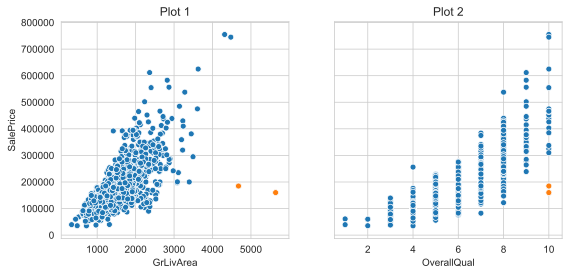

In [11]:
fig, axes = plt.subplots(1,2, figsize= (9,4), sharex=False, sharey=True)

f = housing['GrLivArea'] > 4600
sns.scatterplot(housing['GrLivArea'],housing['SalePrice'],ax = axes[0]);
sns.scatterplot(housing.loc[f,'GrLivArea'],housing.loc[f,'SalePrice'],ax = axes[0]);
axes[0].set_title('Plot 1');
sns.scatterplot(housing['OverallQual'],housing['SalePrice'],ax = axes[1]);
sns.scatterplot(housing.loc[f,'OverallQual'],housing.loc[f,'SalePrice'],ax = axes[1]);
axes[1].set_title('Plot 2');

In [12]:
### Dropping two potential outliers
outlier_1 = 524
outlier_2 = 1299
housing.drop(labels = [outlier_1,outlier_2],inplace=True)

### 5. Features Engineering<a class="anchor" id="features_engineering"></a>

#### 5.A. Creating New Features From Existing Features<a class="anchor" id="creating_new_Features"></a>

1) Some features such as `GrLivArea` and `TotalBsmtSF` measure the living area above ground and the total basement area in square feet, respectively. Thus, we combined the two features into one attribute that describes the total area of a house. 

2) Some features such as the `FullBath` and `BsmtFullBath` describe the number of full bathrooms above ground and in the basement, respectively. So, we combine the two features into one attribute that describes the total number of full bathroom in a house. Similarly, we also combine `BsmtHalfBath` and `HalfBath` into one feature that describes the total number of half bathroom in a house. 

3) There are only 12 houses out of total 2919 houses with pools, so we thought that the measurements in `PoolArea` should be converted binary features with a house either has a pool or doesn't have a pool. 

4) We also create two new features `IsModel` and `HouseAge` which describe whether a house had been remodeled or not and the age of a house, respectively. 

5) We dropped the features that were used to create new features to avoid redundancy of information. Additionally, we dropped the variables `1stFlrSF` and `2ndFlrSF` because the sum of the two variables create `GrLivArea`. We also dropped `BsmtFinSF1`, `BsmtFinSF2`,and `BsmtUnfSF` because the combination of the three variables create `TotalBsmtSF`. 


In [13]:
### 1.
housing['TotArea'] = (housing['GrLivArea'] + housing['TotalBsmtSF'])

### 2.
housing['TotFullBath'] = housing['FullBath'] + housing['BsmtFullBath']

housing['TotHalfBath'] = housing['BsmtHalfBath'] + housing['HalfBath']

### 3.
housing['HasPool'] = np.where(housing['PoolArea'],'1','0')

### 4.
housing['HouseAge'] = housing['YrSold'] - housing['YearBuilt']

housing['IsModel'] = np.where(housing['YearBuilt'] - housing['YearRemodAdd'],'1','0')

### 5.
housing.drop(labels=['GrLivArea','TotalBsmtSF','FullBath','BsmtFullBath','BsmtHalfBath',
                     'HalfBath','1stFlrSF','2ndFlrSF','BsmtFinSF1','BsmtFinSF2',
                     'BsmtUnfSF','PoolArea'],
            axis=1,inplace = True)


#### 5.B. Modified Year-Related Variables<a class="anchor" id="modified_years"></a>

We decided to change the 118 distinct years from the three years-related variables `YearBuilt`,`YearRemodAdd`, and `GarageYrBlt` to only 7 distinct levels because we will model the years-related variables as categorical instead of numerical. We have two reasons why we modified the variables. 

The first reason is upon examining scatter plots of the years-related variables with the sale price, we discovered that the average sales from year-to-year basis doesn't varied much, thus we didn't change the orginal variables much. The year ranges from 1872 to 2010 and the new levels are: 1872-1900,1900-1920,1920-1940,1940-1960,1960-1980,1980-2000, >2000. We placed each observation into one of the levels according to when it was built or remodeled.

The second reason follows the first reason that we considered the years-related variables as categorical therefore if kept the orignal observations, we will have to add 117 new variables. This creates unnecessary more variables when each individual variable doesn't account much for the total variation of the response. We hope that the seven new variables will adequately describe the variation of the reponse while maintaning as much information as the original 118 variables. The plot of one of the variables can be seen in Section 6.C.3. Year Built. 

In [14]:
###
### converting to bins for Year built
###
def convert_yearbuilt(housing,year_built):
    years = housing[year_built].unique()
    for year in years:
        f = housing[year_built] == year  
        if year >= 2000:
            housing.loc[f,year_built] = '2000'   
        elif year >=1980:
            housing.loc[f,year_built] = '1980'
        elif year >= 1960:
            housing.loc[f,year_built] = '1960'
        elif year >= 1940:
            housing.loc[f,year_built] = '1940'
        elif year >= 1920:
            housing.loc[f,year_built] = '1920'
        elif year >=1900:
            housing.loc[f,year_built] = '1900'
        elif year >=1872:
            housing.loc[f,year_built] = '1870'
        else:
            housing.loc[f,year_built] = 'NA'
    return(housing)

years = ['YearBuilt','YearRemodAdd','GarageYrBlt']
for e in years:
    housing = convert_yearbuilt(housing,e)

#### 5.C. Modified Type of  Variables<a class="anchor" id="modified_type"></a>

There are three variables that we think would be more meaningful if they were treated as categical instead of numerical variables. Thus, we converted them to string variables. 

In [15]:
###
### Convert to string instead of number
### 

string_vars = ['MoSold','MSSubClass','YrSold']

def num_to_str(feature):
    housing[feature] = housing[feature].astype(str)

for e in string_vars:
    num_to_str(e)

### 6. Data Visualizations<a class="anchor" id="Data_visualizations"></a>

In [16]:
housing_train = housing.loc[:1460]

In [17]:
def get_type_features(housing):
    obj_vars = [e for e in housing_train.columns if housing_train[e].dtype =='object']
    num_vars= [e for e in housing_train.columns if housing_train[e].dtype =='int64' 
               or housing_train[e].dtype =='float64'
              or housing_train[e].dtype == 'int8']
    return(obj_vars,num_vars)
  
obj_features,num_features = get_type_features(housing_train)

#### 6.A. Correlation Between Variables<a class="anchor" id="Correlations"></a>

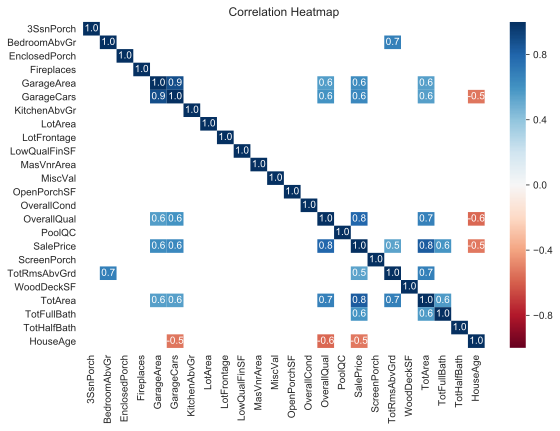

In [18]:
# Create correlation matrix from train data excluding `price`
corr_mat = housing_train.corr()
# Select correlations greater than 0.5
high_corr_mat = corr_mat[abs(corr_mat) >= 0.5]

# Plot correlation heatmap
plt.figure(figsize=(9,6))

ax = sns.heatmap(high_corr_mat,
            annot=True,
            fmt='.1f',
            cmap='RdBu',
            vmin=-1,
           vmax = 1)
title = plt.title('Correlation Heatmap')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);  
# the correlation matrix is cut off from the top and bottom so add 0.5 to each

#### 6.B. Principal Component Analysis<a class="anchor" id="pca"></a>

We are are strong correlations between some of the variables, so we used principal component analysis(PCA) to reduce the number of features as much as we could while maintaining as much as variability in the data as possible. We scaled the data first because the units of these features are different. After performing PCA, ~80% of the the total variability in the data can be explained with only 12 numerical features instead of original 24. 

In [19]:
from sklearn.decomposition import PCA 

scaler = StandardScaler()
scaled_data = scaler.fit_transform(housing_train[num_features]) 
pca = PCA(n_components = 12)
pca.fit_transform(scaled_data)
print(round(np.sum(pca.explained_variance_ratio_),1)*100,'percent of total variablity in the data')


80.0 percent of total variablity in the data


#### 6.C. Scatter Plots of Numerics Features<a class="anchor" id="Scatter_plots"></a>

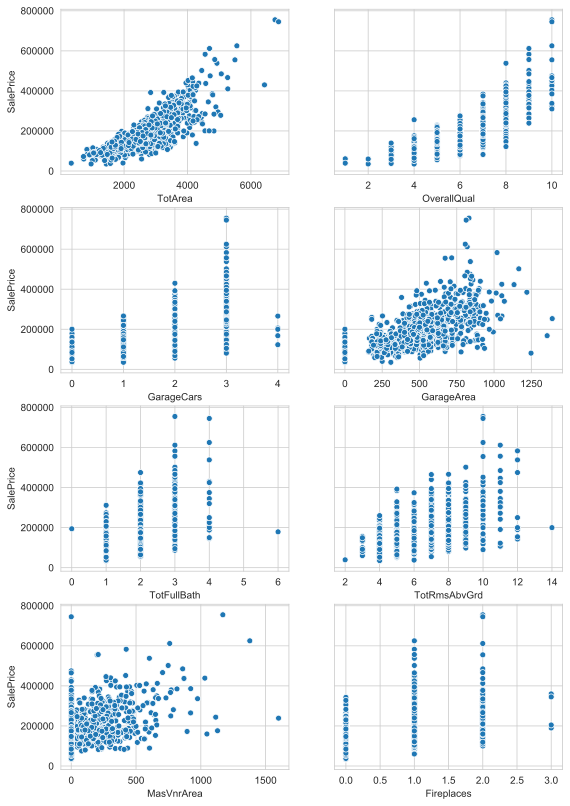

In [20]:
corr_matrix = housing_train.corr()

top_8_num = list(corr_matrix['SalePrice'].sort_values(ascending=False).index[1:9])

fig, axes = plt.subplots(4,2, figsize= (9,14), sharex=False, sharey=True)
k = 0
for i in range(4):
    for j in range(2):
        sns.scatterplot(housing_train[top_8_num[k]], housing_train['SalePrice'],ax = axes[i,j])
        k +=1

#### 6.D. Distribution Plots<a class="anchor" id="Distributions"></a>

#### 6.D.1. Quality-Related Variables<a class="anchor" id="Quality_related"></a>

In [21]:
def ordered_cat(cat_var,reverse=False):
    s = housing_train.groupby(cat_var)['SalePrice'].median()
    s.sort_values(axis=0, ascending=reverse, inplace=True)
    return(s.index)

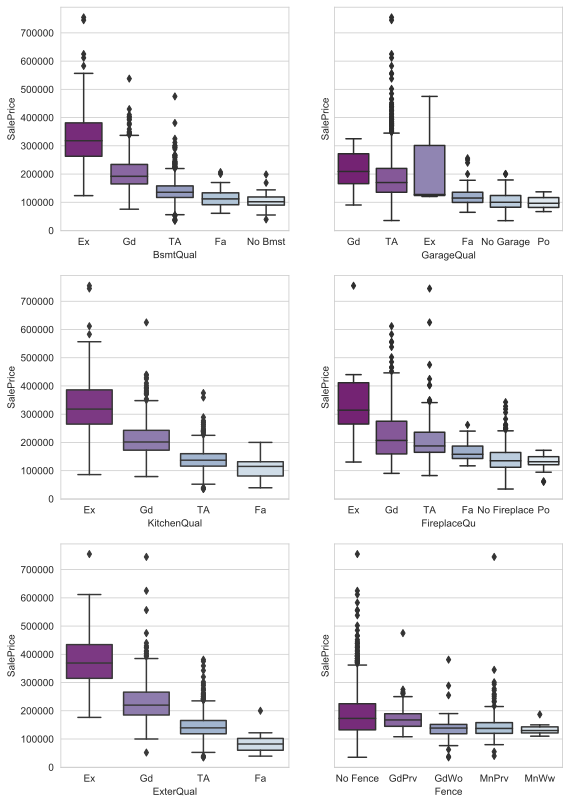

In [22]:
quality_features = ['BsmtQual','GarageQual','KitchenQual','FireplaceQu','ExterQual','Fence']
fig, axes = plt.subplots(3,2, figsize= (9,14), sharex=False, sharey=True)
k = 0
for i in range(3):
    for j in range(2):
        sns.boxplot(housing_train[quality_features[k]], housing_train['SalePrice'],
                    ax = axes[i,j], order = ordered_cat(quality_features[k]),palette="BuPu_r")
        k +=1

#### 6.D.2. House Style and Building Type<a class="anchor" id="style"></a>

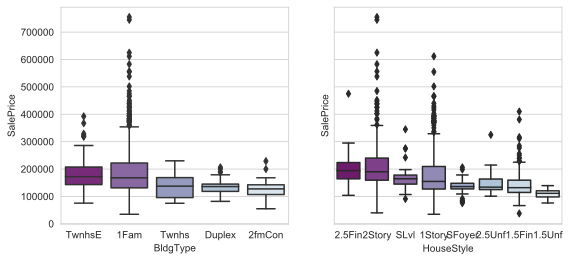

In [23]:
bld_styles = ['BldgType','HouseStyle']
k = 0
fig, axes = plt.subplots(1,2, figsize= (9,4), sharex=False, sharey=True)

sns.boxplot(housing_train[bld_styles[0]], housing_train['SalePrice'],ax = axes[0],
            order = ordered_cat(bld_styles[0]),palette="BuPu_r")

sns.boxplot(housing_train[bld_styles[1]], housing_train['SalePrice'],ax = axes[1],
           order = ordered_cat(bld_styles[1]),palette="BuPu_r");


#### 6.D.3. Year Built<a class="anchor" id="year_built"></a>

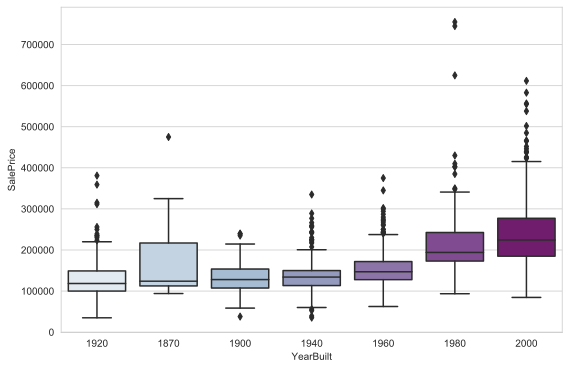

In [24]:
plt.figure(figsize=(9,6))

sns.boxplot(housing_train['YearBuilt'], housing_train['SalePrice'],
            order = ordered_cat('YearBuilt',reverse=True),palette="BuPu") 


#### 6.D.4. Neighboorhood<a class="anchor" id="Neighborhood"></a>

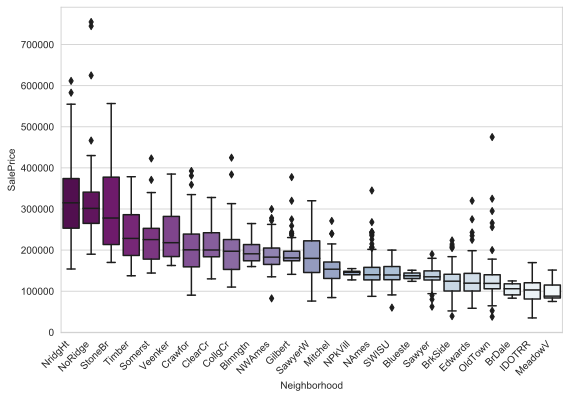

In [25]:
plt.figure(figsize=(9,6))
ax = sns.boxplot(housing_train['Neighborhood'],housing_train['SalePrice'],
                 order = ordered_cat('Neighborhood'),palette="BuPu_r")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

#### 7. Helper Functions<a class="anchor" id="Helper_Functions"></a>

In [26]:
def plot_residuals(y_true,y_pred,model):
    '''
    Plot predictions against residuals
    '''
    sns.scatterplot(x=y_pred,y=y_true-y_pred)
    sns.lineplot(x=y_pred,y=[0]*len(y_pred),c = 'k')
    plt.xlabel('predictions')
    plt.ylabel('residuals')
    plt.title('Residuals Plot from '+model)
    
    
    
import sklearn.metrics as metrics

def get_performance_stats(model, y_true, y_pred):
    '''
    Print summary statistics of a given model
    '''
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('R-squared:          ', round(r2,4))
    
    
def plot_learning_curves(model, X_train, X_val, y_train,y_val):  
    
    train_errors, val_errors = [],[]
  
    for m in range(1, X_train.shape[0],10):
        
        model.fit(X_train[:m], y_train[:m])
        
        y_train_predict = model.predict(X_train[:m])  # predict on the m training points
        
        y_val_predict = model.predict(X_val)  # predict on the full validation test
        
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict)) # between 
        
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors),"r-", linewidth=1, label="train") 
    plt.plot(np.sqrt(val_errors), "b-", linewidth=1, label="val")
    plt.legend()
    
def transform_X(X, num_vars, obj_vars):
    
    scaler = StandardScaler()

    X[num_vars] = scaler.fit_transform(X[num_vars]) 
    
    X = pd.get_dummies(X,columns = obj_vars, drop_first=True)
    
    return X

import scipy.stats as stats

def qqplot(X,title):
    '''
    Plot distribution of data to access normality
    '''
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].hist(X)
    axes[0].set_title('Distribution Plot of '+title)

    axes[1] = stats.probplot((X), dist="norm",plot=plt)
    plt.title('Distribution Plot of '+title)
    plt.tight_layout()
    
def top_features(df,column_name,n_features=40):
    '''
    Gets the top most important features
    '''
    df_new = df.sort_values(by=column_name,axis=0,ascending=False)
    
    return(list(df_new.index[:n_features]))


### 8. Modelling<a class="anchor" id="Modelling"></a>

In [27]:

obj_features,num_features = get_type_features(housing_train)

num_features.remove('SalePrice')

housing_prep = transform_X(housing[num_features+obj_features],num_features, obj_features)

housing[num_features+obj_features]


N_train = 1460
train = housing_prep.loc[:N_train]
sale_train = housing.loc[:N_train,'SalePrice']


X_train, X_val, y_train, y_val = train_test_split(train,np.log(sale_train),test_size = 0.2, random_state =42)

X_test = housing_prep.loc[N_train+1:]
y_test = housing.loc[N_train+1:,'SalePrice']

print("Dimension of train data set:     ",X_train.shape)
print("Dimension of response train set: ",y_train.shape)
print("Dimension of val set:            ",X_val.shape)
print("Dimension of response val set:   ",y_val.shape)
print("Dimension of test set:           ",X_test.shape)
print("Dimension of response test set:  ",y_test.shape)



Dimension of train data set:      (1166, 290)
Dimension of response train set:  (1166,)
Dimension of val set:             (292, 290)
Dimension of response val set:    (292,)
Dimension of test set:            (1459, 290)
Dimension of response test set:   (1459,)


#### 8.A. Checking For Normality Assumption of the Response<a class="anchor" id="Normality_Assumptions"></a>

Some of the statistical models that we will use depend on one of the assumptions that the response must be normally distributed. The distribution of the original response is highly askew therefore we used the logarithmic transformation to normalize the reponse. After the transformation, the distriution of the log sal eprice is approximately normal distributed. From this point forward, we will use the log sale price instead of the original sale price variable for our analyses. 

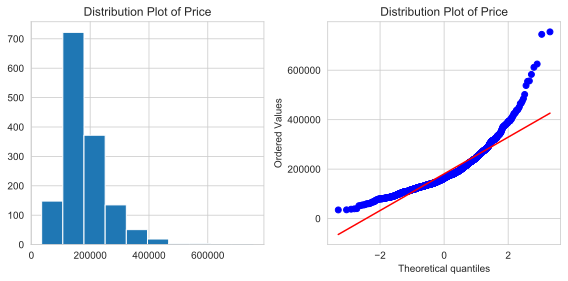

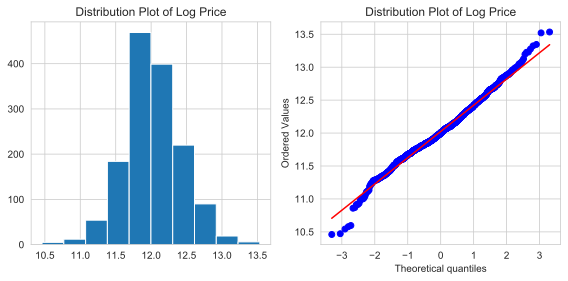

In [28]:
qqplot(housing_train['SalePrice'],title='Price')
qqplot(np.log(housing_train['SalePrice']),title='Log Price')

In [29]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

#### 8.B. Parameters Tuning<a class="anchor" id="Parameters_Tuning"></a>

In [30]:
####
#### Performing Grid Search with Ridge Regression
####

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'alpha':list(np.linspace(15,20 , 10))}]
    
grid_search = GridSearchCV(Ridge(), param_grid,cv=10,scoring = 'neg_mean_squared_error',
                           return_train_score = True)
grid_search.fit(X_train, y_train)

ridge_alpha = list(grid_search.best_params_.values())[0]


In [31]:
### LASSO PARAMETERS SEARCH

param_grid = [
    {'alpha':list(np.linspace(0.00001,0.001, 100))}]

grid_search = GridSearchCV(Lasso(max_iter = 3000), param_grid,cv=10,scoring = 'neg_mean_squared_error',
                           return_train_score = True)
grid_search.fit(X_train, y_train)

lasso_alpha = list(grid_search.best_params_.values())[0]


In [32]:
from sklearn.ensemble import RandomForestRegressor  

param_grid = [
    {'n_estimators':[i for i in range(10,100,10)], 'max_features':[i for i in range(1,20,2)],
    'max_depth':[i for i in range(1,7,1)]}
]

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5,
                           scoring='neg_mean_squared_error',return_train_score=True)

grid_search.fit(X_train,y_train)

rf_max_depth = list(grid_search.best_params_.values())[0]
rf_max_features = list(grid_search.best_params_.values())[1]
rf_n_estimators = list(grid_search.best_params_.values())[2]

#### 8.C. Relevant Features Exploration<a class="anchor" id="features_exploration"></a>

In [33]:
names = X_train.columns
ranks = {}

def rank_to_dict(ranks, names,order=1):
    '''
    This estimator scales and translates each feature individually 
    such that it is in the given range on the training set, e.g. between zero and one.
    '''
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x:round(x,2),ranks)
    return(dict(zip(names,ranks)))

### Ridge
ridge = Ridge(alpha = ridge_alpha)
ridge.fit(X_train, y_train)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)

### Lasso
lasso = Lasso(alpha = lasso_alpha)
lasso.fit(X_train, y_train)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)

#### Random forest
rf = RandomForestRegressor(n_estimators = rf_n_estimators,max_features = rf_max_features,
                          max_depth=rf_max_depth)
rf.fit(X_train,y_train)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)

r = {}
for name in names:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)

#### a list of names of different methods for selecting subsets of features
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

df = pd.DataFrame(ranks)
index = ['Ridge', 'Lasso','RF','Mean']
df = df.reindex(columns = index)

#### Top Fifteen Features For Ridge, Lasso, and Random Forest <a class="anchor" id="#top_15"></a>

In [35]:
ridge_f = top_features(df,'Ridge',n_features=15)
lasso_f = top_features(df,'Lasso',n_features=15)
rf_f = top_features(df,'RF',n_features=15)
avg_f = top_features(df,'Mean',n_features=15)
pd.DataFrame({"Ridge":ridge_f,'Lasso':lasso_f,'Random Forest':rf_f,'Mean':avg_f},
             index = range(1,len(avg_f)+1))

Ridge                 Lasso             Random Forest  \
1                TotArea               TotArea                   TotArea   
2   Neighborhood_Crawfor  Neighborhood_Crawfor               OverallQual   
3            OverallQual  Neighborhood_StoneBr                GarageCars   
4   Neighborhood_StoneBr          SaleType_New                GarageArea   
5           CentralAir_Y           MSZoning_FV                   LotArea   
6    Exterior1st_BrkFace   Exterior1st_BrkFace          Foundation_PConc   
7               HouseAge          Heating_Grav                Fireplaces   
8            OverallCond           OverallQual               TotFullBath   
9        Condition1_Norm              HouseAge            KitchenQual_TA   
10          SaleType_New          CentralAir_Y              ExterQual_Gd   
11       BsmtExposure_Gd  Neighborhood_BrkSide              ExterQual_TA   
12  SaleCondition_Normal           Street_Pave                  HouseAge   
13         MSSubClass_30           MSZoning_RL              TotRmsAbvGrd   
14        Functional_Typ         MSSubClass_30  FireplaceQu_No Fireplace   
15  Neighborhood_BrkSide           OverallCond               BsmtQual_TA   

                    Mean  
1                TotArea  
2            OverallQual  
3   Neighborhood_Crawfor  
4   Neighborhood_StoneBr  
5             GarageArea  
6               HouseAge  
7             GarageCars  
8           SaleType_New  
9    Exterior1st_BrkFace  
10           MSZoning_FV  
11          CentralAir_Y  
12           OverallCond  
13           TotFullBath  
14          Heating_Grav  
15         MSSubClass_30

In [36]:
set(ridge_f) & set(lasso_f) & set(rf_f)


{'HouseAge', 'OverallQual', 'TotArea'}

Some of the features that all three methods agree are: `Total Area`, `Overall Quality`, and `House Age`. The `Total Area` and `Overall Quality` are highly correlated with the response, thus it's not suprising that they showed up in all three methods. The rest of the features are different. 

### 8.D. Fitting Possible Models<a class="anchor" id="Parameters_Tuning"></a>

#### 8.D.1 Ridge Regression<a class="anchor" id="Ridge_Regression"></a>

In [37]:
ridge_features = top_features(df,'Ridge')

param_grid = [
    {'alpha':list(np.linspace(1,10,50))}]
    
grid_search = GridSearchCV(Ridge(), param_grid,cv=10,scoring = 'neg_mean_squared_error',
                           return_train_score = True)
grid_search.fit(X_train[ridge_features], y_train)

ridge_alpha = list(grid_search.best_params_.values())[0]

ridge_regression = Ridge(alpha = ridge_alpha)
ridge_regression.fit(X_train[ridge_features],y_train)
ridge_predictions = ridge_regression.predict(X_train[ridge_features])
get_performance_stats(ridge_regression, y_train, ridge_predictions)

explained_variance:  0.9135
R-squared:           0.9135


#### 8.D.2 Lasso Regression<a class="anchor" id="Lasso_Regression"></a>

In [38]:
lasso_features = top_features(df,'Lasso')

param_grid = [
    {'alpha':list(np.linspace(0.00001,0.0001, 100))}]

grid_search = GridSearchCV(Lasso(max_iter = 3000), param_grid,cv=10,scoring = 'neg_mean_squared_error',
                           return_train_score = True)
grid_search.fit(X_train[lasso_features], y_train)

lasso_alpha = list(grid_search.best_params_.values())[0]

lasso_regression = Ridge(alpha = lasso_alpha)
lasso_regression.fit(X_train[lasso_features],y_train)
lasso_predictions = lasso_regression.predict(X_train[lasso_features])
mse = mean_squared_error(y_train,lasso_predictions)
get_performance_stats(lasso_regression, y_train, lasso_predictions)



explained_variance:  0.9248
R-squared:           0.9248


#### 8.D.3 Random Forest <a class="anchor" id="Random_Forest_Regression"></a>

rf_features = top_features(df,'RF')

param_grid = [
    {'n_estimators':[i for i in range(50,150,10)], 'max_features':[i for i in range(1,20,2)],
    'max_depth':[i for i in range(1,7,1)],'max_leaf_nodes':[i for i in range(6,32,3)]}
]

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5,
                           scoring='neg_mean_squared_error',return_train_score=True)

grid_search.fit(X_train[rf_features],y_train);

grid_search.best_params_.values()### [6,13,30,80]


In [39]:
rf_max_leaf_nodes = 30
rf_n_estimators = 80
rf_max_depth = 6
rf_max_features = 13
rf_features = top_features(df,'RF')
rf = RandomForestRegressor(n_estimators=rf_n_estimators, 
                           max_depth=rf_max_depth,
                           max_leaf_nodes = rf_max_leaf_nodes,
                           max_features = rf_max_features 
                          )
rf.fit(X_train[rf_features],y_train)
rf_predictions = rf.predict(X_train[rf_features])
get_performance_stats(rf, y_train, rf_predictions)

explained_variance:  0.9044
R-squared:           0.9044


#### 8.D.4 Gradient Boosting Regression<a class="anchor" id="gradient"></a>

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
mean_features = top_features(df,'Mean')
gbrt = GradientBoostingRegressor(max_depth=3, n_estimators=100,learning_rate=0.5)
gbrt.fit(X_train[mean_features], y_train)
gbrt_predictions = gbrt.predict(X_train[mean_features])
get_performance_stats(gbrt, y_train, gbrt_predictions)

explained_variance:  0.9832
R-squared:           0.9832


#### 8.E Models Diagnostics<a class="anchor" id="Models_Diagnostics"></a>

#### 8.E.1 Learning Curves<a class="anchor" id="Learning_curves"></a>

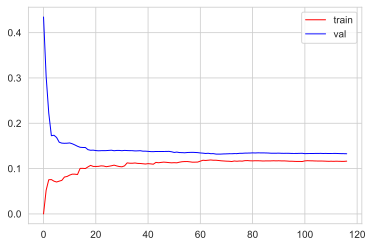

In [41]:
plot_learning_curves(ridge_regression, X_train[ridge_features], X_val[ridge_features], y_train,y_val)


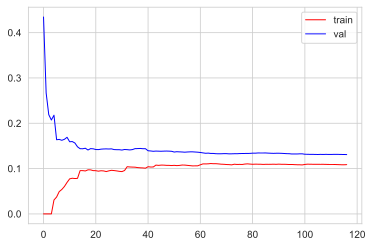

In [42]:
plot_learning_curves(lasso_regression, X_train[lasso_features], X_val[lasso_features], y_train,y_val)

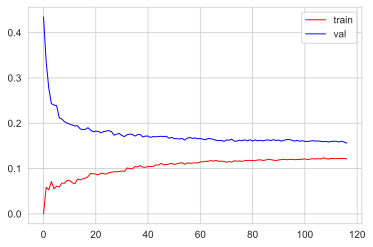

In [43]:
plot_learning_curves(rf, X_train[rf_features], X_val[rf_features], y_train,y_val)

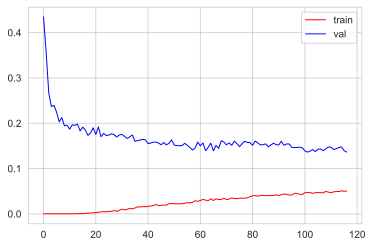

In [44]:
plot_learning_curves(gbrt, X_train[mean_features], X_val[mean_features], y_train,y_val)

#### 8.E.2. Residuals Plots <a class="anchor" id="Residuals_plots"></a>

Another assumption for some of the statistical models such as Ridge and Lasso Regression require the distribution of the errors be normal. We accessed the normality by plotting the residuals against the predicted values. We also plotted the residuals from Random Forest and Boosting models to check if there are any patterns to the residuals from each model. The four residuals plots show that the normality assumption for the errors is approximately satisfied. From the residuals plots, we can also plot possible outliers as well. 

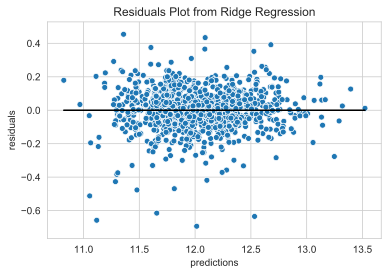

In [45]:
plot_residuals(y_train,ridge_predictions,model='Ridge Regression')   

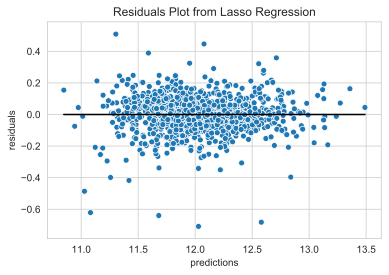

In [46]:
plot_residuals(y_train,lasso_predictions,'Lasso Regression')

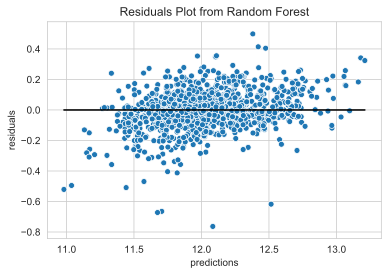

In [47]:
plot_residuals(y_train,rf_predictions,'Random Forest')

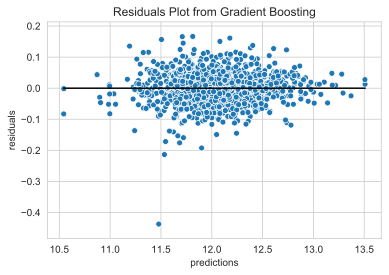

In [48]:
plot_residuals(y_train,gbrt_predictions,'Gradient Boosting')

#### 8.F. Predictions<a class="anchor" id="Predictions"></a>

In [49]:
ridge_features= top_features(df,'Ridge')

X = pd.concat([X_train,X_val])
y = pd.concat([y_train,y_val])

param_grid = [
    {'alpha':list(np.linspace(5,15, 100))}]

grid_search = GridSearchCV(Ridge(), param_grid,cv=10,scoring = 'neg_mean_squared_error',
                           return_train_score = True)

grid_search.fit(X[ridge_features],y)

ridge_alpha = list(grid_search.best_params_.values())[0]


In [50]:
lasso_features = top_features(df,'Lasso')

param_grid = [
    {'alpha':list(np.linspace(0.00001, 0.001, 1000))}]

grid_search = GridSearchCV(Lasso(), param_grid,cv=5,scoring = 'neg_mean_squared_error',
                           return_train_score = True)

grid_search.fit(X[lasso_features], y)


lasso_alpha = list(grid_search.best_params_.values())[0]


In [51]:
def predict():
    ridge_regression = Ridge(ridge_alpha)
    ridge_regression.fit(X[ridge_features],y)

    lasso_regression = Lasso(lasso_alpha)
    lasso_regression.fit(X[lasso_features],y)
    
    rf = RandomForestRegressor(n_estimators=rf_n_estimators, 
                           max_depth=rf_max_depth,
                           max_leaf_nodes = rf_max_leaf_nodes,
                        max_features = rf_max_features)
    rf.fit(X[rf_features],y)

    gbrt = GradientBoostingRegressor(max_depth=3, n_estimators=100,learning_rate=0.5)
    gbrt.fit(X[mean_features], y)
    
    df = {'Ridge':np.exp(ridge_regression.predict(X_test[ridge_features])),
    'Lasso':np.exp(lasso_regression.predict(X_test[lasso_features])),
    'Random Forest':np.exp(rf.predict(X_test[rf_features])),
    'Boosting':np.exp(gbrt.predict(X_test[mean_features]))}

    predictions_df = pd.DataFrame(df,index=X_test.index)
    predictions_df['Predictions'] = predictions_df.mean(axis=1)
    return(predictions_df)

predictions_df = predict()
predictions_df['Predictions'].head(50)

Id
1461    116091.194321
1462    158114.882378
1463    169974.647176
1464    190078.735866
1465    204479.548840
1466    170198.317681
1467    184817.708822
1468    165284.831223
1469    199075.893489
1470    117096.517123
1471    195776.258047
1472     98160.756212
1473    100146.546126
1474    148199.457094
1475    121729.694582
1476    367721.078581
1477    251757.110824
1478    293487.607877
1479    301170.919798
1480    543067.523536
1481    336525.794108
1482    219936.492137
1483    178909.835344
1484    173739.820873
1485    183757.395377
1486    199826.967186
1487    318796.560921
1488    236870.775127
1489    196317.126523
1490    217021.947718
1491    182204.281310
1492     82702.734854
1493    189604.515998
1494    280470.106741
1495    280404.125726
1496    240660.771896
1497    175927.106281
1498    160299.211103
1499    158953.919781
1500    147847.460920
1501    167813.727600
1502    157098.584466
1503    274421.660946
1504    238530.388342
1505    234137.885682
1506   

### 9. Conclusion<a class="anchor" id="Conclusion"></a>

After checking for assumptions of each model, we combined the four models' predictions 
into the final predictions. There is small gap between the validation errors and traning curves for Ridge Regression, Lasso Regression, Random Forest Regression. We also see a large gap in the learning gap between the training error and validation error lines of Gradient Boosting Regression. This phenomenon is an indication that we have overfitted the data, especially in the Boosting model. This means that the model performs very well with the validation data but cannot generalize with new data. One suggestion to reduce the gap between the validation and training curve is to reduce the number of features that was used for training the model. 